<a href="https://colab.research.google.com/github/niyaryca/AMLDataset/blob/main/AML_COURSEWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neattext

In [ ]:
# Load EDA Pkgs
import pandas as pd
import numpy as np
import neattext.functions as nfx
import seaborn as sns

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.utils import to_categorical

### **Loading DataSet**

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/niyaryca/AMLDataset/main/processed_reviews_split_surnamesJ_minimal.csv')
data.head()

,review_id,text,verified,review_score,product_category
0,product_review_000000,I can't even remember the first time I finishe...,False,5.0,video_games
1,product_review_000001,Ernie Ball's Electric Acoustic sound dull. I h...,True,-1.0,musical_instruments
2,product_review_000002,Anyone who buys this game because it's markete...,False,5.0,video_games
3,product_review_000003,The system had a burn in the screen and kept g...,True,3.0,video_games
4,product_review_000004,As this is a remake/remaster review I will not...,True,-1.0,video_games


# **Preprocessing Data**

### **Explanatory Data Analysis**

In [ ]:
data.describe()
data.dropna(subset=['text'])
print(data['review_score'].value_counts())

 5.0    19280
 4.0     6205
 3.0     3109
 1.0     1872
 2.0     1545
-1.0      907
Name: review_score, dtype: int64


the reviews are negative as well which are not acceptable so removing the rows which have negative values

In [ ]:
data.loc[data.review_score<0,'review_score'] = np.nan

from sklearn.impute import SimpleImputer 

data_no_nulls =  data.copy()
imptr_num = SimpleImputer(missing_values = np.nan, strategy = 'mean')  
print(data.isnull().sum())
print(data.shape)
column = ['review_score']
imptr_num = imptr_num.fit(data_no_nulls[column])

data_no_nulls['review_score'] = imptr_num.transform(data_no_nulls[column]) 

print(data_no_nulls.isnull().sum())

review_id             0
text                 10
verified            121
review_score        907
product_category    906
dtype: int64
(32918, 5)
review_id             0
text                 10
verified            121
review_score          0
product_category    906
dtype: int64


now checking for the categorical columns

In [ ]:
categorical_columns = ['verified','review_score','product_category']
data.head()
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  print(data[col].value_counts())
  print("\n")

imptr_empl = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')  

# 2. Fit the imputer object to the feature matrix
imptr_empl = imptr_empl.fit(data[categorical_columns])

# 3. Call Transform to replace missing data in train_dataset (on specific columns) by the mean of the column to which that missing data belongs to
data_no_nulls[categorical_columns] = imptr_empl.transform(data[categorical_columns]) 

print(data_no_nulls.isnull().sum())


Categories and number of occurrences for 'verified'
True     23342
False     9455
Name: verified, dtype: int64


Categories and number of occurrences for 'review_score'
5.0    19280
4.0     6205
3.0     3109
1.0     1872
2.0     1545
Name: review_score, dtype: int64


Categories and number of occurrences for 'product_category'
video_games            21868
musical_instruments    10144
Name: product_category, dtype: int64


review_id            0
text                10
verified             0
review_score         0
product_category     0
dtype: int64


Seems like all the other categorical columns are fine now and the null values are replaced with the most recent one.

**Removing data where the reviews are null because nothing can be done for that as the whole prediction depends on this feature.**

In [ ]:
print(data_no_nulls.isna().sum())
data_no_nulls = data_no_nulls.dropna()
print(data_no_nulls.isna().sum())


review_id            0
text                10
verified             0
review_score         0
product_category     0
dtype: int64
review_id           0
text                0
verified            0
review_score        0
product_category    0
dtype: int64


### **Text Preprocessing**

**Removing Stopwords**

In [ ]:
dir(nfx)
processed_data = data_no_nulls
processed_data['clean_reviews']= processed_data['text'].apply(nfx.remove_stopwords)

**Removing Special Characters**

In [ ]:
processed_data['clean_reviews']= processed_data['clean_reviews'].apply(nfx.remove_special_characters)

**Text to Lowercase**

In [ ]:
processed_data['clean_reviews']= processed_data['clean_reviews'].str.lower()

**Comparing with the original text**

In [ ]:
processed_data[['clean_reviews','text']].head()

,clean_reviews,text
0,cant remember time finished game going review ...,I can't even remember the first time I finishe...
1,ernie balls electric acoustic sound dull repla...,Ernie Ball's Electric Acoustic sound dull. I h...
2,buys game marketed rpg going hate it turn base...,Anyone who buys this game because it's markete...
3,system burn screen kept going usb mode way fix...,The system had a burn in the screen and kept g...
4,remakeremaster review traditional review tell ...,As this is a remake/remaster review I will not...


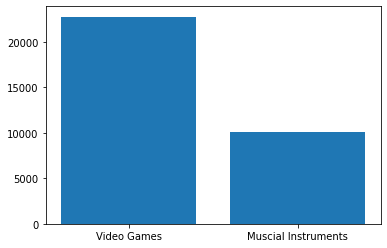

5.0    20178
4.0     6204
3.0     3109
1.0     1872
2.0     1545
Name: review_score, dtype: int64
[20178, 3109, 6204, 1872, 1545]


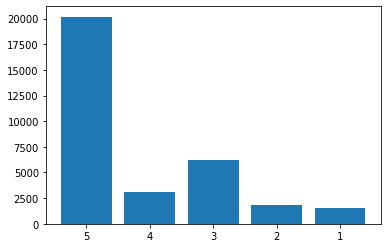

In [ ]:
import matplotlib.pyplot as plt

category_classes = processed_data.product_category.unique()
category_counts = []
rating_classes = processed_data.review_score.unique()
rating_counts = []

for i in category_classes:
  count = len(processed_data[processed_data.product_category==i])
  category_counts.append(count)

plt.bar(['Video Games', 'Muscial Instruments'], category_counts)
plt.show()

for i in rating_classes:
  count = len(processed_data[processed_data.review_score==i])
  rating_counts.append(count)

print(processed_data['review_score'].value_counts())
print(rating_counts)
plt.bar(['5', '4','3','2','1'], rating_counts)
plt.show()


# **1st Algorithm (Logistic Regression)**



### **Building Features**

In [ ]:
reviews_features = processed_data['clean_reviews']
category_labels = processed_data['product_category']
rating_labels = processed_data['review_score']

Convert words to vectors using TfidfVectorizer

In [ ]:
tfidf_vector = TfidfVectorizer()
reviews = tfidf_vector.fit_transform(reviews_features)

In [ ]:
reviews_train,reviews_test,category_train,category_test,rating_train,rating_test = train_test_split(reviews,category_labels,rating_labels, test_size=0.2,random_state=42)

***Building Model***

In [ ]:
model_category = LogisticRegression()
category_prediction = model_category.fit(reviews_train,category_train).predict(reviews_test)

In [ ]:
model_rating = LinearSVC()

rating_train=rating_train.astype('float')
rating_test=rating_test.astype('float')
rating_prediction = model_rating.fit(reviews_train,rating_train).predict(reviews_test)

In [ ]:
print(model_category.score(reviews_test,category_test))
print(model_rating.score(reviews_test,rating_test))

0.9325432999088423
0.6607414159829839


In [ ]:
print(classification_report(category_prediction,category_test))
print(classification_report(rating_prediction,rating_test))

                     precision    recall  f1-score   support

musical_instruments       0.88      0.90      0.89      1980
        video_games       0.95      0.95      0.95      4602

           accuracy                           0.93      6582
          macro avg       0.92      0.92      0.92      6582
       weighted avg       0.93      0.93      0.93      6582

              precision    recall  f1-score   support

         1.0       0.45      0.58      0.51       291
         2.0       0.15      0.38      0.21       122
         3.0       0.25      0.40      0.31       391
         4.0       0.26      0.39      0.31       823
         5.0       0.90      0.74      0.81      4955

    accuracy                           0.66      6582
   macro avg       0.40      0.50      0.43      6582
weighted avg       0.75      0.66      0.70      6582



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


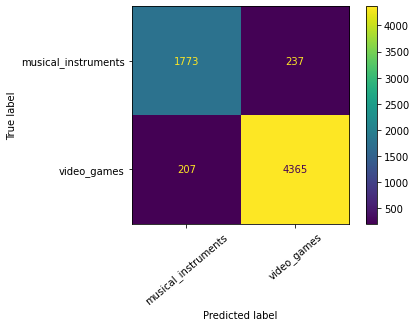

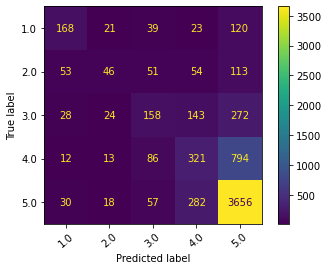

In [ ]:
confusion_matrix(category_prediction,category_test)
plot_confusion_matrix(model_category,reviews_test,category_test,xticks_rotation=40)

confusion_matrix(category_prediction,category_test)
plot_confusion_matrix(model_rating,reviews_test,rating_test,xticks_rotation=40)

In [ ]:
def prediction(text):
    my_vec = tfidf_vector.transform([text])
    text_array = my_vec.toarray()
    category = model_category.predict(text_array)[0]
    rating = model_rating.predict(text_array)[0]
    return "Predicted Category: " + category + "/n Predicted Rating: " + str(rating)

In [ ]:
prediction("I am dissapoint from this game")

'Predicted Category: video_games/n Predicted Rating: 5.0'

# **2nd Algorithm**

In [ ]:
import nltk
nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews_features, category_labels, stratify=category_labels, random_state=42,test_size=0.1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 1887


In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_dim = 100  # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential()  # initiates the model
model.add(layers.Embedding(input_dim=vocab_size,  # adds the first [input] layer which will be our tokenized tweets
                          output_dim=embedding_dim,  # the embedding of that tweet, essentially inputs output
                          input_length=maxlen))  # size of the input layer determined by maxlen calculated before
model.add(layers.Dropout(0.2))  # dorpouts are added to help with overtraining, essentially "turns off" said amount of neurons before giving information to the next layer
model.add(layers.GlobalMaxPool1D())  # https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))  # additional hidden layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))  # prediction layer, 2 is the number of classes we have
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1887, 100)         6484300   
                                                                 
 dropout (Dropout)           (None, 1887, 100)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                        

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))



category_prediction = clf_sgd.fit(reviews_train, category_train).predict(reviews_test)
# print(classification_report(category_prediction,category_test))

rating_prediction = clf_sgd.fit(reviews_train,rating_train).predict(reviews_test)
print(classification_report(rating_prediction,rating_test))

-- Epoch 1
Norm: 0.10, NNZs: 54356, Bias: 0.002921, T: 23693, Avg. loss: 0.689163
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 0.09, NNZs: 55285, Bias: 0.002917, T: 47386, Avg. loss: 0.648665
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 0.09, NNZs: 55632, Bias: 0.002915, T: 71079, Avg. loss: 0.643842
Total training time: 0.18 seconds.
-- Epoch 4
Norm: 0.09, NNZs: 55661, Bias: 0.002914, T: 94772, Avg. loss: 0.641148
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 0.09, NNZs: 55675, Bias: 0.002913, T: 118465, Avg. loss: 0.639651
Total training time: 0.26 seconds.
-- Epoch 6
Norm: 0.09, NNZs: 55687, Bias: 0.002912, T: 142158, Avg. loss: 0.638763
Total training time: 0.29 seconds.
Convergence after 6 epochs took 0.30 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 0.12, NNZs: 46458, Bias: -0.006679, T: 23693, Avg. loss: 0.538296
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.11, NNZs: 47970, Bias: -0.006835, T: 47386, Avg. loss: 0.493350
Total training time: 0.06 seconds.
Norm: 0.12, NNZs: 44497, Bias: -0.006719, T: 23693, Avg. loss: 0.525464
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 48549, Bias: -0.006928, T: 71079, Avg. loss: 0.490972
Total training time: 0.09 seconds.
-- Epoch 2
-- Epoch 4
Norm: 0.11, NNZs: 48661, Bias: -0.006993, T: 94772, Avg. loss: 0.487629Norm: 0.11, NNZs: 46624, Bias: -0.006871, T: 47386, Avg. loss: 0.492140
Total training time: 0.15 seconds.

Total training time: 0.15 seconds.
-- Epoch 3
-- Epoch 5
Norm: 0.11, NNZs: 47022, Bias: -0.006961, T: 71079, Avg. loss: 0.487502
Total training time: 0.19 seconds.
Norm: 0.11, NNZs: 48732, Bias: -0.007045, T: 118465, Avg. loss: 0.486242
Total training time: 0.21 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.11, NNZs: 48753, Bias: -0

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [ ]:
# history = model.fit(X_train, y_train, validation_split=0.11, epochs=15, batch_size=32, verbose=1)#,callbacks=callbacks)